In [1]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

from skimage.io import imread, imshow
from skimage.transform import resize

import os
from glob import glob
from distutils.dir_util import copy_tree

In [2]:
def evaluate_model(model, x_test, y_test, class_labels,softmax=False):
    # Generate predictions for the test set
    y_pred = model.predict(x_test)
    if softmax:
        y_pred = [np.argmax(x) for x in y_pred]
    else:
        y_pred = list(map(np.round, y_pred))
    # Get the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(3, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, xticklabels=class_labels, yticklabels=class_labels)
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    
    # Show the plot
    plt.show()
    
    # Print the classification report
    cr = classification_report(y_test, y_pred, target_names=class_labels)
    print(cr)


In [3]:
input_dir = "/kaggle/input/multi-cancer/Dataset"
brain_dir = os.path.join(input_dir,"Brain scans")
breast_dir = os.path.join(input_dir,"Breast scans")

brain_noTumor_dir = os.path.join(brain_dir,'No tumor')
brain_noTumor_train_dir = os.path.join(brain_noTumor_dir,"Train")
brain_noTumor_test_dir = os.path.join(brain_noTumor_dir,"Test")

brain_Tumor_dir = os.path.join(brain_dir,'Tumor')
brain_Tumor_train_dir = os.path.join(brain_Tumor_dir,"TRAIN")
brain_Tumor_test_dir = os.path.join(brain_Tumor_dir,"TEST")

breast_normal_dir = os.path.join(breast_dir,'normal')
breast_benign_dir = os.path.join(breast_dir,'benign')
breast_malignant_dir = os.path.join(breast_dir, 'malignant')

breast_normal_train_dir = os.path.join(breast_normal_dir,'Train')
breast_normal_test_dir = os.path.join(breast_normal_dir,'Test')

breast_benign_train_dir = os.path.join(breast_benign_dir,'Train')
breast_benign_test_dir = os.path.join(breast_benign_dir,'Test')

breast_malignant_train_dir = os.path.join(breast_malignant_dir,'Train')
breast_malignant_test_dir = os.path.join(breast_malignant_dir,'Test')

In [4]:
root_dir = "/kaggle/working"
brain_vs_breast_dir = os.path.join(root_dir,'brain-vs-breast')
brain_dir = os.path.join(root_dir,'brain-classifier')
breast_dir = os.path.join(root_dir,'breast-classifier')

In [5]:
%%time
dest_root = brain_vs_breast_dir
for dir1 in ['Train','Test']:
    for dir2 in ['Brain',"Breast"]:
        if dir2 == "Brain":
            dest = os.path.join(dest_root,dir1,dir2)
            os.makedirs(dest,exist_ok=True)
            eval(f"copy_tree(brain_noTumor_{dir1.lower()}_dir,dest)")
            eval(f"copy_tree(brain_Tumor_{dir1.lower()}_dir,dest)")
        if dir2 == "Breast":
            dest = os.path.join(dest_root,dir1,dir2)
            os.makedirs(dest)
            for image_path in eval(f"glob(breast_normal_{dir1.lower()}_dir+'/*).png')")+ eval(f"glob(breast_benign_{dir1.lower()}_dir+'/*).png')") + eval(f"glob(breast_malignant_train_dir+'/*).png')"):
                shutil.copy(image_path,dest)
        

CPU times: user 274 ms, sys: 680 ms, total: 954 ms
Wall time: 9.04 s


In [6]:
%%time
dest_root = brain_dir
for dir1 in ['Train','Test']:
    for dir2 in ['Tumor',"noTumor"]:
        dest = os.path.join(dest_root,dir1,dir2)
        os.makedirs(dest,exist_ok=True)
        eval(f"copy_tree(brain_{dir2}_{dir1.lower()}_dir,dest)")
        

CPU times: user 119 ms, sys: 187 ms, total: 305 ms
Wall time: 1.83 s


In [7]:
%%time
dest_root = breast_dir
for dir1 in ['Train','Test']:
    for dir2 in ['normal',"benign","malignant"]:
        dest = os.path.join(dest_root,dir1,dir2)
        os.makedirs(dest)
        for image_path in eval(f"glob(breast_{dir2}_{dir1.lower()}_dir+'/*).png')"):
            shutil.copy(image_path,dest)
        

CPU times: user 120 ms, sys: 325 ms, total: 446 ms
Wall time: 1.13 s


# Brain vs Breast

In [8]:
input_shape = (256,256)
train_datagen = ImageDataGenerator(
    
    width_shift_range=0.2,  # shift images horizontally by up to 20%
    height_shift_range=0.2, # shift images vertically by up to 20%
    shear_range=0.1,        # shear images by up to 10%
    zoom_range=0.1,         # zoom in on images by up to 10%
    rescale = 1/255,
    validation_split=0.1
)
test_datagen = ImageDataGenerator(rescale = 1/255)

train_data = train_datagen.flow_from_directory(
    os.path.join(brain_vs_breast_dir,"Train"),
    target_size=input_shape,  # resize images to 224x224 pixels
    batch_size=32,           # batch size for training
        
    class_mode='binary',
    subset='training'
)
print(train_data.class_indices)


validation_dataset = train_datagen.flow_from_directory(
    os.path.join(brain_vs_breast_dir,"Train"),
     target_size=input_shape,  # resize images to 224x224 pixels
    batch_size=32, 
    class_mode='binary' # batch size for validation
    ,subset='validation'
)
test_generator = test_datagen.flow_from_directory(
   os.path.join(brain_vs_breast_dir,"Test"),
    target_size=input_shape,
    batch_size=32,
    class_mode='binary')


base_model = VGG16(weights='imagenet', include_top=False, input_shape=(input_shape[0], input_shape[1], 3))

for layer in base_model.layers:
    layer.trainable = False
# Add a new classification layer on top of the pre-trained layers
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dense(256, activation='relu'))

model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])


callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
# The exact amount of patience will vary between models and problems. there a rule of thumb to make it 10% of number of epoch.

history = model.fit(train_data,
                    validation_data=validation_dataset,
                    epochs=10,callbacks=[callback, tf.keras.callbacks.ModelCheckpoint(filepath='brain-vs-breast-model.h5', monitor='val_loss', save_best_only=True)])

Found 1514 images belonging to 2 classes.
{'Brain': 0, 'Breast': 1}
Found 168 images belonging to 2 classes.
Found 449 images belonging to 2 classes.
58889256/58889256 [==============================] - 4s 0us/step
Epoch 1/10
48/48 [==============================] - 43s 687ms/step - loss: 0.1771 - accuracy: 0.9630 - val_loss: 1.3825e-06 - val_accuracy: 1.0000
Epoch 2/10
48/48 [==============================] - 30s 635ms/step - loss: 0.0030 - accuracy: 0.9993 - val_loss: 1.8850e-04 - val_accuracy: 1.0000
Epoch 3/10
48/48 [==============================] - 31s 637ms/step - loss: 0.0163 - accuracy: 0.9987 - val_loss: 1.1040e-12 - val_accuracy: 1.0000


In [9]:
# Define the folders for the images
test_brain_folder = os.path.join(brain_vs_breast_dir,'Test','Brain')
test_Breast_folder = os.path.join(brain_vs_breast_dir,'Test','Breast')

# Create empty arrays for X_test and y_test
brain_imgs = glob(test_brain_folder+'/*.jpg')
breast_imgs = glob(test_Breast_folder+'/*.png')
n = len(brain_imgs) + len(breast_imgs)
X_test = np.zeros((n,input_shape[0],input_shape[1],3))
y_test = []

# Load the images from the test tumor folder
for i,filename in enumerate(breast_imgs):
    img = resize(imread(filename),(input_shape[0],input_shape[1],3))
    if img is not None:
        X_test[i] = img
        y_test.append(1)  # Class label for Breast
j=i+1
# Load the images from the test no tumor folder
for i,filename in enumerate(brain_imgs):
    img = resize(imread(filename),(input_shape[0],input_shape[1],3))
    #print(img.shape)
    if img is not None:
        X_test[j+i] = img
        y_test.append(0)  # Class label for Brain

# Convert the lists to numpy arrays
y_test = np.array(y_test)
X_test.shape,y_test.shape

((449, 256, 256, 3), (449,))

15/15 [==============================] - 2s 94ms/step


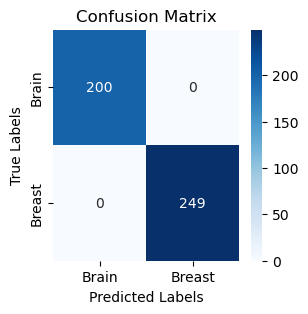

              precision    recall  f1-score   support

       Brain       1.00      1.00      1.00       200
      Breast       1.00      1.00      1.00       249

    accuracy                           1.00       449
   macro avg       1.00      1.00      1.00       449
weighted avg       1.00      1.00      1.00       449



In [10]:
evaluate_model(model, X_test, y_test,train_data.class_indices.keys())

# Brain Classifier

In [11]:
input_shape = (256,256)
train_datagen = ImageDataGenerator(
    
    width_shift_range=0.2,  # shift images horizontally by up to 20%
    height_shift_range=0.2, # shift images vertically by up to 20%
    shear_range=0.1,        # shear images by up to 10%
    zoom_range=0.1,         # zoom in on images by up to 10%
    rescale = 1/255,
    validation_split=0.2
)
test_datagen = ImageDataGenerator(rescale = 1/255)

train_data = train_datagen.flow_from_directory(
    os.path.join(brain_dir,"Train"),
    target_size=input_shape,  
    batch_size=32,           
        
    class_mode='binary',
    subset='training'
)
print(train_data.class_indices)

validation_dataset = train_datagen.flow_from_directory(
    os.path.join(brain_dir,"Train"),
     target_size=input_shape,  
    batch_size=32, 
    class_mode='binary'
    ,subset='validation'
)
test_generator = test_datagen.flow_from_directory(
    os.path.join(brain_dir,"Test"),
    target_size=input_shape,
    batch_size=32,
    class_mode='binary')


# Define the CNN architecture
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu',  input_shape=(input_shape[0], input_shape[1], 3)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(32, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Flatten())
model2.add(layers.Dense(512,activation='relu'))
model2.add(layers.Dense(256,activation='relu'))
model2.add(layers.Dense(128,activation='relu'))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model2.fit(train_data,
                    validation_data=validation_dataset,
                    epochs=200,
                    callbacks = tf.keras.callbacks.ModelCheckpoint(filepath='brain-classifier.h5', monitor='val_loss', save_best_only=True))

print(model2.evaluate(test_generator))

Found 801 images belonging to 2 classes.
{'Tumor': 0, 'noTumor': 1}
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Epoch 1/200
26/26 [==============================] - 19s 580ms/step - loss: 0.6925 - accuracy: 0.5119 - val_loss: 0.6919 - val_accuracy: 0.5000
Epoch 2/200
26/26 [==============================] - 15s 594ms/step - loss: 0.6936 - accuracy: 0.5006 - val_loss: 0.6880 - val_accuracy: 0.5000
Epoch 3/200
26/26 [==============================] - 15s 565ms/step - loss: 0.6768 - accuracy: 0.5468 - val_loss: 0.6913 - val_accuracy: 0.5350
Epoch 4/200
26/26 [==============================] - 15s 586ms/step - loss: 0.6558 - accuracy: 0.6030 - val_loss: 0.6534 - val_accuracy: 0.6500
Epoch 5/200
26/26 [==============================] - 15s 567ms/step - loss: 0.6211 - accuracy: 0.6954 - val_loss: 0.5836 - val_accuracy: 0.7300
Epoch 6/200
26/26 [==============================] - 15s 593ms/step - loss: 0.5524 - accuracy: 0.7179 - val_loss: 0.6022 - val_acc

In [12]:
# Define the folders for the images
test_tumor_folder = os.path.join(brain_dir,'Test','Tumor')
test_noTumor_folder = os.path.join(brain_dir,'Test','noTumor')

# Create empty arrays for X_test and y_test
tumor_imgs = glob(test_tumor_folder+'/*.jpg')
noTumor_imgs = glob(test_noTumor_folder+'/*.jpg')
n = len(tumor_imgs) + len(noTumor_imgs)
X_test = np.zeros((n,input_shape[0],input_shape[1],3))
y_test = []


for i,filename in enumerate(noTumor_imgs):
    img = resize(imread(filename),(input_shape[0],input_shape[1],3))
    if img is not None:
        X_test[i] = img
        y_test.append(1)  
j=i+1

for i,filename in enumerate(tumor_imgs):
    img = resize(imread(filename),(input_shape[0],input_shape[1],3))
    #print(img.shape)
    if img is not None:
        X_test[j+i] = img
        y_test.append(0)  


y_test = np.array(y_test)
X_test.shape,y_test.shape

((200, 256, 256, 3), (200,))

7/7 [==============================] - 0s 14ms/step


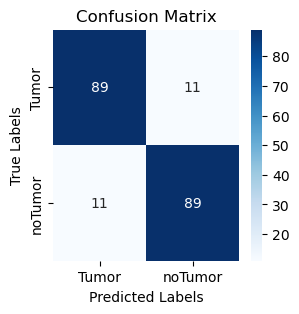

              precision    recall  f1-score   support

       Tumor       0.89      0.89      0.89       100
     noTumor       0.89      0.89      0.89       100

    accuracy                           0.89       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.89      0.89      0.89       200



In [13]:
evaluate_model(model2, X_test, y_test,train_data.class_indices.keys())

# Breast Classifier

In [14]:
input_shape = (256,256)
train_datagen = ImageDataGenerator(
    
    width_shift_range=0.2,  # shift images horizontally by up to 20%
    height_shift_range=0.2, # shift images vertically by up to 20%
    shear_range=0.1,        # shear images by up to 10%
    zoom_range=0.1,         # zoom in on images by up to 10%
    rescale = 1/255,
    validation_split=0.1
)
test_datagen = ImageDataGenerator(rescale = 1/255)

train_data = train_datagen.flow_from_directory(
    os.path.join(breast_dir,"Train"),
    target_size=input_shape,  
    batch_size=16,           
        
    class_mode='categorical',
    subset='training'
)
print(train_data.class_indices)

validation_dataset = train_datagen.flow_from_directory(
    os.path.join(breast_dir,"Train"),
     target_size=input_shape,  
    batch_size=16, 
    class_mode='categorical' 
    ,subset='validation'
)
test_generator = test_datagen.flow_from_directory(
    os.path.join(breast_dir,"Test"),
    target_size=input_shape,
    batch_size=32,
    class_mode='categorical')

# Define the CNN architecture
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu',  input_shape=(input_shape[0],input_shape[1], 3)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(32, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Flatten())
model2.add(layers.Dense(512,activation='relu'))
model2.add(layers.Dense(256,activation='relu'))
model2.add(layers.Dense(128,activation='relu'))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(3, activation='softmax'))

# Compile the model
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model2.fit(train_data,
                    validation_data=validation_dataset,
                    epochs=200,
                    callbacks = tf.keras.callbacks.ModelCheckpoint(filepath='breast-classifier.h5', monitor='val_loss', save_best_only=True))

print(model2.evaluate(test_generator))

Found 614 images belonging to 3 classes.
{'benign': 0, 'malignant': 1, 'normal': 2}
Found 67 images belonging to 3 classes.
Found 99 images belonging to 3 classes.
Epoch 1/200
39/39 [==============================] - 18s 376ms/step - loss: 0.9756 - accuracy: 0.5847 - val_loss: 0.9844 - val_accuracy: 0.5821
Epoch 2/200
39/39 [==============================] - 15s 384ms/step - loss: 0.9276 - accuracy: 0.5847 - val_loss: 1.0336 - val_accuracy: 0.5821
Epoch 3/200
39/39 [==============================] - 14s 369ms/step - loss: 0.9533 - accuracy: 0.5847 - val_loss: 0.9545 - val_accuracy: 0.5821
Epoch 4/200
39/39 [==============================] - 15s 389ms/step - loss: 0.9387 - accuracy: 0.5847 - val_loss: 1.0078 - val_accuracy: 0.5821
Epoch 5/200
39/39 [==============================] - 14s 364ms/step - loss: 0.9060 - accuracy: 0.5847 - val_loss: 0.9179 - val_accuracy: 0.5821
Epoch 6/200
39/39 [==============================] - 15s 380ms/step - loss: 0.8822 - accuracy: 0.5863 - val_loss: 0.

In [15]:
# Define the folders for the images
test_benign_folder = os.path.join(breast_dir,'Test','benign')
test_malignant_folder = os.path.join(breast_dir,'Test','malignant')
test_normal_folder = os.path.join(breast_dir,'Test','normal')


# Create empty arrays for X_test and y_test
benign_imgs = glob(test_benign_folder+'/*).png')
malignant_imgs = glob(test_malignant_folder+'/*).png')
normal_imgs = glob(test_normal_folder+'/*).png')


n = len(benign_imgs) + len(malignant_imgs)+ len(normal_imgs)
X_test = np.zeros((n,input_shape[0],input_shape[1],3))
y_test = []


for i,filename in enumerate(malignant_imgs):
    img = resize(imread(filename),(input_shape[0],input_shape[1],3))
    if img is not None:
        X_test[i] = img
        y_test.append(1) 
j=i+1

for i,filename in enumerate(benign_imgs):
    img = resize(imread(filename),(input_shape[0],input_shape[1],3))
    #print(img.shape)
    if img is not None:
        X_test[j+i] = img
        y_test.append(0)  
j=j+i+1        
for i,filename in enumerate(normal_imgs):
    img = resize(imread(filename),(input_shape[0],input_shape[1],3))
    #print(img.shape)
    if img is not None:
        X_test[j+i] = img
        y_test.append(2)  


y_test = np.array(y_test)
X_test.shape,y_test.shape

((99, 256, 256, 3), (99,))

4/4 [==============================] - 0s 11ms/step


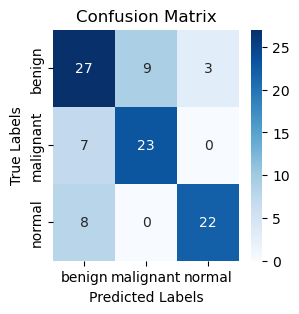

              precision    recall  f1-score   support

      benign       0.64      0.69      0.67        39
   malignant       0.72      0.77      0.74        30
      normal       0.88      0.73      0.80        30

    accuracy                           0.73        99
   macro avg       0.75      0.73      0.74        99
weighted avg       0.74      0.73      0.73        99



In [16]:
evaluate_model(model2, X_test, y_test,train_data.class_indices.keys(),softmax=True)

In [17]:
!rm -r '/kaggle/working/brain-vs-breast'
!rm -r '/kaggle/working/breast-classifier'
!rm -r '/kaggle/working/brain-classifier'